# Lesson 7. Attribute and Spatial Joins

Now that we understand the logic of spatial relationship queries,
let's take a look at another fundamental spatial operation that relies on them.

This operation, called a **spatial join**, is the process by which we can
leverage the spatial relationships between distinct datasets to merge
their information into a new, synthetic dataset.

This operation can be thought as the spatial equivalent of an
**attribute join**, in which multiple tabular datasets can be merged by
aligning matching values in a common column that they both contain.
Thus, we'll start by developing an understanding of this operation first!

- 7.0 Data Input and Prep
- 7.1 Attribute Joins
- **Exercise**: Choropleth Map
- 7.2 Spatial Joins
- 7.3 Aggregation
- **Exercise**: Aggregation
- 7.4 Recap

<br>
<font color='grey'>
    <b>Instructor Notes</b>

- Datasets used
    - 'notebook_data/census/ACS5yr/census_variables_CA.csv'
    - 'notebook_data/census/Tracts/cb_2013_06_tract_500k.zip'
    - 'notebook_data/alco_schools.csv'
    
- Expected time to complete
    - Lecture + Questions: 45 minutes
    - Exercises: 20 minutes
</font>

In [1]:
library(sf)
library(tmap)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.2



# 7.0 Data Input and Prep

Let's read in a table of data from the US Census' 5-year American Community Survey (ACS5).

In [3]:
# Read in the ACS5 data for CA into an `sf` object.
# Note: We force the FIPS_11_digit to be read in as a string to preserve any leading zeroes.
acs5_df = read.csv("notebook_data/census/ACS5yr/census_variables_CA.csv")
head(acs5_df)

,NAME,c_race,c_white,c_black,c_asian,c_latinx,c_race_moe,c_white_moe,c_black_moe,c_asian_moe,⋯,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"Census Tract 4012, Alameda County, California",2456,1287,476,259,283,213,191,116,124,⋯,0.8149510,0.10334967,0.05841503,0.010212418,0.013071895,0.5513699,0.06438356,0.1890411,0.08356164,0.05821918
2,"Census Tract 4013, Alameda County, California",3983,845,1348,827,796,680,186,411,283,⋯,0.6118653,0.28004022,0.06334842,0.022624434,0.022121669,0.3411535,0.10899316,0.3914956,0.01808407,0.10459433
3,"Census Tract 4014, Alameda County, California",4340,713,1902,593,981,644,314,440,198,⋯,0.8076833,0.16373858,0.01780276,0.006324666,0.004450691,0.4708464,0.02131661,0.2557994,0.11661442,0.10219436
4,"Census Tract 4015, Alameda County, California",2080,563,1064,215,190,369,222,283,116,⋯,0.8413462,0.10144231,0.05384615,0.003365385,0.000000000,0.5020367,0.09063136,0.2301426,0.04786151,0.01731161
5,"Census Tract 4016, Alameda County, California",1889,324,960,247,274,400,135,376,164,⋯,0.8306452,0.07956989,0.08225806,0.002150538,0.005376344,0.5704809,0.12271973,0.1774461,0.06301824,0.00000000
6,"Census Tract 4017, Alameda County, California",2544,553,634,302,945,314,140,259,144,⋯,0.7893491,0.13806706,0.04575937,0.013412229,0.013412229,0.4088328,0.17917981,0.2353312,0.01324921,0.01829653


**Brief summary of the data**:

Below is a table of the variables in this table. They were combined from 
different ACS 5 year tables.

<u>NOTE</u>:
- variables that start with `c_` are counts
- variables that start with `med_` are medians
- variables that end in `_moe` are margin of error estimates
- variables that start with `_p` are proportions calcuated from the counts divided by the table denominator (the total count for whom that variable was assessed)


| Variable        | Description                                     |
|-----------------|-------------------------------------------------|
|`c_race`         |Total population                                 
|`c_white`        |Total white non-Latinx
| `c_black`       | Total black and African American non-Latinx
| `c_asian`       | Total Asian non-Latinx
| `c_latinx`      | Total Latinx
| `state_fips`    | State level FIPS code
| `county_fips`   | County level FIPS code
| `tract_fips`    |Tracts level FIPS code
| `med_rent`      |Median rent
| `med_hhinc`     |Median household income
| `c_tenants`     |Total tenants
| `c_owners`      |Total owners
| `c_renters`     |Total renters
| `c_movers`      |Total number of people who moved
| `c_stay`        |Total number of people who stayed
| `c_movelocal`   |Number of people who moved locally
| `c_movecounty`  |Number of people who moved counties
| `c_movestate`   | Number of people who moved states
| `c_moveabroad`  |Number of people who moved abroad
| `c_commute`     |Total number of commuters
| `c_car`         | Number of commuters who use a car
| `c_carpool`     | Number of commuters who carpool
| `c_transit`     |Number of commuters who use public transit
| `c_bike`        |Number of commuters who bike
| `c_walk`        |Number of commuters who bike
| `year`          | ACS data year
| `FIPS_11_digit` | 11-digit FIPS code


We're going to drop all of our `moe` columns by identifying all of those that end with `_moe`. We can do that in two steps, first by using `filter` to identify columns that contain the string `_moe`.

In [ ]:
moe_cols = acs5_df.filter(like='_moe',axis=1).columns
moe_cols

In [ ]:
acs5_df.drop(moe_cols, axis=1, inplace=True)

And lastly, let's grab only the rows for year 2018 and county FIPS code 1 (i.e. Alameda County)

In [4]:
acs5_df_ac = acs5_df[acs5_df$year==2018 & acs5_df$county_fips==1, ]

---------------------------------
Now let's also read in our census tracts again!

In [6]:
tracts_sf = st_read("./notebook_data/census/Tracts/cb_2013_06_tract_500k.shp")

Reading layer `cb_2013_06_tract_500k' from data source `/home/drew/Desktop/stuff/berk/dlab/Geospatial-Fundamentals-in-R-with-sf/rewrite/notebook_data/census/Tracts/cb_2013_06_tract_500k.shp' using driver `ESRI Shapefile'
Simple feature collection with 8043 features and 9 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -124.4096 ymin: 32.53416 xmax: -114.1312 ymax: 42.00952
geographic CRS: NAD83


In [8]:
head(tracts_sf)

ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called ‘geojsonio’

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,MULTIPOLYGON (((-122.2642 3...
2,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,MULTIPOLYGON (((-122.2856 3...
3,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,MULTIPOLYGON (((-122.304 37...
4,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,MULTIPOLYGON (((-122.276 37...
5,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,MULTIPOLYGON (((-122.2182 3...
6,06,001,406100,1400000US06001406100,06001406100,4061,CT,1843685,74875,MULTIPOLYGON (((-122.2387 3...


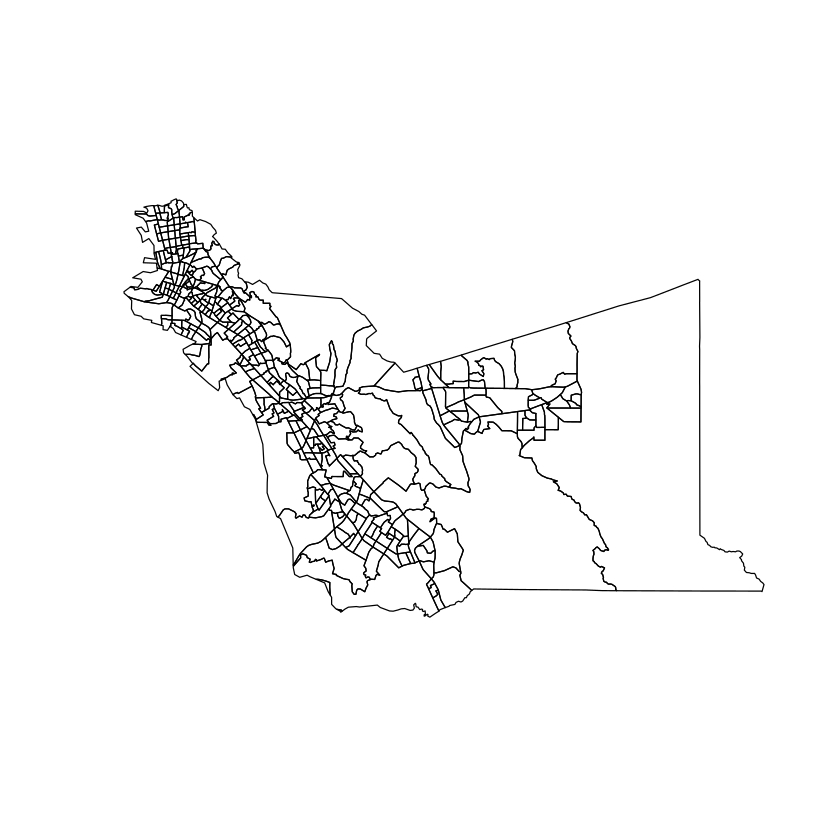

In [11]:
tracts_sf_ac = tracts_sf[tracts_sf$COUNTYFP == '001',]
plot(tracts_sf_ac$geometry)

# 7.1 Attribute Joins

**Attribute Joins  between `sf` data.frames and plain data.frames**

*We just mapped the census tracts. But what makes a map powerful is when you map the data associated with the locations.*

- `tracts_sf_ac`: These are polygon data in an `sf` data.frame. However, as we saw in the `head` of that dataset, they no attributes of interest!

- `acs5_df_ac`: These are 2018 ACS data from a CSV file ('census_variables_CA.csv'), imported and read in as a plain data.frame. However, they have no geometries!

In order to map the ACS data we need to associate it with the tracts. Let's do that now, by joining the columns from `acs5_df_ac` to the columns of `tracts_gdf_ac` using a common column as the key for matching rows. This process is called an **attribute join**.






--------------------------

<img src="https://documentation.mindsphere.io/resources/html/predictive-learning/en-US/Joins_Diagram.png">


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

The image above gives us a nice conceptual summary of the types of joins we could run.

1. In general, why might we choose one type of join over another?
1. In our case, do we want an inner, left, right, or outer (AKA 'full') join? 

(**NOTE**: You can read more about merging `sf` and plain data.frames [here](https://r-spatial.github.io/sf/reference/merge.sf.html).)

Okay, here we go!

Let's take a look at the common column in both our data.frames.


In [13]:
head(tracts_sf_ac['GEOID'])

ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called ‘geojsonio’

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

,GEOID,geometry
,<chr>,<MULTIPOLYGON [°]>
1,06001400300,MULTIPOLYGON (((-122.2642 3...
2,06001400900,MULTIPOLYGON (((-122.2856 3...
3,06001402200,MULTIPOLYGON (((-122.304 37...
4,06001402800,MULTIPOLYGON (((-122.276 37...
5,06001404800,MULTIPOLYGON (((-122.2182 3...
6,06001406100,MULTIPOLYGON (((-122.2387 3...


In [14]:
head(acs5_df_ac['FIPS_11_digit'])

,FIPS_11_digit
,<dbl>
8324,6001441501
8325,6001404700
8326,6001442500
8327,6001450300
8328,6001450607
8329,6001404900



Note that they are **not named the same thing**. 
        
        That's okay! We just need to know that they contain the same information.

Also note that they are **not in the same order**. 
        
        That's not only okay... That's the point! (If they were in the same order already then we could just join them side by side, without having R find and line up the matching rows from each!)

-------------------------------

Let's do a `left` join to keep all of the census tracts in Alameda County and only the ACS data for those tracts.

**NOTE**: To figure out how to do this we could always take a peek at the documentation by calling
`?base::merge`.

In [15]:
?base::merge

In [17]:
# Left join keeps all tracts and the acs data for those tracts
tracts_acs_sf_ac = base::merge(tracts_sf_ac, acs5_df_ac, by.x = 'GEOID', by.y = "FIPS_11_digit", all.x=TRUE)
head(tracts_acs_sf_ac)

ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called ‘geojsonio’

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

GEOID       STATEFP COUNTYFP TRACTCE AFFGEOID             NAME.x LSAD ALAND  
1 06001400100 06      001      400100  1400000US06001400100 4001   CT   6894334
2 06001400200 06      001      400200  1400000US06001400200 4002   CT    587453
3 06001400300 06      001      400300  1400000US06001400300 4003   CT   1105329
4 06001400400 06      001      400400  1400000US06001400400 4004   CT    714729
5 06001400500 06      001      400500  1400000US06001400500 4005   CT    590307
6 06001400600 06      001      400600  1400000US06001400600 4006   CT    297856
  AWATER NAME.y geometry                       ⋯ p_movelocal p_movecounty
1 0      NA     MULTIPOLYGON (((-122.2469 3... ⋯ NA          NA          
2 0      NA     MULTIPOLYGON (((-122.2574 3... ⋯ NA          NA          
3 0      NA     MULTIPOLYGON (((-122.2642 3... ⋯ NA          NA          
4 0      NA     MULTIPOLYGON (((-122.2618 3... ⋯ NA          NA          
5 0      NA     MULTIPOLYGON (((-122.2694 3... ⋯ NA          NA          
6 0      NA     MULTIPOLYGON (((-122.2681 3... ⋯ NA          NA          
  p_movestate p_moveabroad p_car p_carpool p_transit p_bike p_walk
1 NA          NA           NA    NA        NA        NA     NA    
2 NA          NA           NA    NA        NA        NA     NA    
3 NA          NA           NA    NA        NA        NA     NA    
4 NA          NA           NA    NA        NA        NA     NA    
5 NA          NA           NA    NA        NA        NA     NA    
6 NA          NA           NA    NA        NA        NA     NA    
  geometry                      
1 MULTIPOLYGON (((-122.2469 3...
2 MULTIPOLYGON (((-122.2574 3...
3 MULTIPOLYGON (((-122.2642 3...
4 MULTIPOLYGON (((-122.2618 3...
5 MULTIPOLYGON (((-122.2694 3...
6 MULTIPOLYGON (((-122.2681 3...

Let's check that we have all the variables we have in our dataset now.

In [18]:
colnames(tracts_acs_sf_ac)

[1] "GEOID"            "STATEFP"          "COUNTYFP"         "TRACTCE"         
 [5] "AFFGEOID"         "NAME.x"           "LSAD"             "ALAND"           
 [9] "AWATER"           "NAME.y"           "c_race"           "c_white"         
[13] "c_black"          "c_asian"          "c_latinx"         "c_race_moe"      
[17] "c_white_moe"      "c_black_moe"      "c_asian_moe"      "c_latinx_moe"    
[21] "state_fips"       "county_fips"      "tract_fips"       "med_rent"        
[25] "med_hhinc"        "c_tenants"        "c_owners"         "c_renters"       
[29] "med_rent_moe"     "med_hhinc_moe"    "c_tenants_moe"    "c_owners_moe"    
[33] "c_renters_moe"    "c_movers"         "c_stay"           "c_movelocal"     
[37] "c_movecounty"     "c_movestate"      "c_moveabroad"     "c_movers_moe"    
[41] "c_stay_moe"       "c_movelocal_moe"  "c_movecounty_moe" "c_movestate_moe" 
[45] "c_moveabroad_moe" "c_commute"        "c_car"            "c_carpool"       
[49] "c_transit"        "c_bike"           "c_walk"           "c_commute_moe"   
[53] "c_car_moe"        "c_carpool_moe"    "c_transit_moe"    "c_bike_moe"      
[57] "c_walk_moe"       "year"             "p_white"          "p_black"         
[61] "p_asian"          "p_latinx"         "p_owners"         "p_renters"       
[65] "p_stay"           "p_movelocal"      "p_movecounty"     "p_movestate"     
[69] "p_moveabroad"     "p_car"            "p_carpool"        "p_transit"       
[73] "p_bike"           "p_walk"           "geometry"

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

It's always important to run sanity checks on our results, at each step of the way!

In this case, how many rows and columns should we have?


In [27]:
print("Rows and columns in the Alameda County Census tract gdf:")
print(dim(tracts_sf_ac))
print("Row and columns in the ACS5 2018 data:")
print(dim(acs5_df_ac))
print("Rows and columns in the Alameda County Census tract gdf joined to the ACS data:")
print(dim(tracts_acs_sf_ac))

[1] "Rows and columns in the Alameda County Census tract gdf:"
[1] 361  10
[1] "Row and columns in the ACS5 2018 data:"
[1] 361  66
[1] "Rows and columns in the Alameda County Census tract gdf joined to the ACS data:"
[1] 361  75


Let's save out our merged data so we can use it in the final notebook.

In [28]:
st_write(tracts_acs_sf_ac, './outdata/tracts_acs_gdf_ac.json', driver='GeoJSON')

Writing layer `tracts_acs_gdf_ac' to data source `./outdata/tracts_acs_gdf_ac.json' using driver `GeoJSON'
Writing 361 features with 74 fields and geometry type Multi Polygon.


## Exercise: Choropleth Map
We can now make choropleth maps using our attribute joined geodataframe. Go ahead and pick one variable to color the map, then map it. You can go back to lesson 5 if you need a refresher on how to make this!

To see the solution, double-click the Markdown cell below.

In [ ]:
# YOUR CODE HERE






## Double-click to see solution!

<!--

# SOLUTION:
fig, ax = plt.subplots(figsize = (10,5)) 
tracts_acs_gdf_ac.plot(column='p_renters', 
                   scheme="quantiles",
                   legend=True,
                   ax=ax,cmap='magma'
                   )
ax.set_title("Percentage of Renters")

-->

-------------------
# 7.2 Spatial Joins

Great! We've wrapped our heads around the concept of an attribute join.

Now let's extend that concept to its spatially explicit equivalent: the **spatial join**!


<br>

To start, we'll read in some other data: The Alameda County schools data.

Then we'll work with that data and our `tracts_acs_sf_ac` data together.

In [29]:
schools_df = read.csv('notebook_data/alco_schools.csv')
schools_sf = st_as_sf(schools_df, coords = c('X', 'Y'), crs=4326)

Let's check if we have to transform the schools to match the`tracts_acs_sf_ac`'s CRS.

In [33]:
print('schools_sf CRS:')
print(st_crs(schools_sf))
print('tracts_acs_sf_ac CRS:')
print(st_crs(tracts_acs_sf_ac))

[1] "schools_sf CRS:"
Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]
[1] "tracts_acs_sf_ac CRS:"
Coordinate Reference System:
  User input: NAD83 
  wkt:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipso

Yes we do! Let's do that.

**NOTE**: Explicit syntax aiming at that dataset's CRS leaves less room for human error!

In [35]:
schools_sf = st_transform(schools_sf, st_crs(tracts_acs_sf_ac))

print('schools_sf CRS:')
print(st_crs(schools_sf))
print('tracts_acs_sf_ac CRS:')
print(st_crs(tracts_acs_sf_ac))

[1] "schools_sf CRS:"
Coordinate Reference System:
  User input: NAD83 
  wkt:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
[1] "tracts_acs_sf_ac CRS:"
Coordinate Reference System:
  User input: NAD83 
  wkt:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXI

Now we're ready to combine the datasets in an analysis.

**In this case, we want to get data from the census tract within which each school is located.**

But how can we do that? The two datasets don't share a common column to use for a join.

In [36]:
colnames(tracts_acs_sf_ac)

[1] "GEOID"            "STATEFP"          "COUNTYFP"         "TRACTCE"         
 [5] "AFFGEOID"         "NAME.x"           "LSAD"             "ALAND"           
 [9] "AWATER"           "NAME.y"           "c_race"           "c_white"         
[13] "c_black"          "c_asian"          "c_latinx"         "c_race_moe"      
[17] "c_white_moe"      "c_black_moe"      "c_asian_moe"      "c_latinx_moe"    
[21] "state_fips"       "county_fips"      "tract_fips"       "med_rent"        
[25] "med_hhinc"        "c_tenants"        "c_owners"         "c_renters"       
[29] "med_rent_moe"     "med_hhinc_moe"    "c_tenants_moe"    "c_owners_moe"    
[33] "c_renters_moe"    "c_movers"         "c_stay"           "c_movelocal"     
[37] "c_movecounty"     "c_movestate"      "c_moveabroad"     "c_movers_moe"    
[41] "c_stay_moe"       "c_movelocal_moe"  "c_movecounty_moe" "c_movestate_moe" 
[45] "c_moveabroad_moe" "c_commute"        "c_car"            "c_carpool"       
[49] "c_transit"        "c_bike"           "c_walk"           "c_commute_moe"   
[53] "c_car_moe"        "c_carpool_moe"    "c_transit_moe"    "c_bike_moe"      
[57] "c_walk_moe"       "year"             "p_white"          "p_black"         
[61] "p_asian"          "p_latinx"         "p_owners"         "p_renters"       
[65] "p_stay"           "p_movelocal"      "p_movecounty"     "p_movestate"     
[69] "p_moveabroad"     "p_car"            "p_carpool"        "p_transit"       
[73] "p_bike"           "p_walk"           "geometry"

In [37]:
colnames(schools_sf)

[1] "Site"     "Address"  "City"     "State"    "Type"     "API"      "Org"     
[8] "geometry"

However, they do have a shared relationship by way of space! 

So, we'll use a spatial relationship query to figure out the census tract that
each school is in, then associate the tract's data with that school (as additional data in the school's row).
This is a **spatial join**!

---------------------------------

### Census Tract Data Associated with Each School

In this case, let's say we're interested in the relationship between the median household income
in a census tract (`tracts_acs_sf_ac$med_hhinc`) and a school's Academic Performance Index
(`schools_gdf$API`).

To start, let's take a look at the distributions of our two variables of interest.

In [40]:
head(tracts_acs_sf_ac)

ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called ‘geojsonio’

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

GEOID       STATEFP COUNTYFP TRACTCE AFFGEOID             NAME.x LSAD ALAND  
1 06001400100 06      001      400100  1400000US06001400100 4001   CT   6894334
2 06001400200 06      001      400200  1400000US06001400200 4002   CT    587453
3 06001400300 06      001      400300  1400000US06001400300 4003   CT   1105329
4 06001400400 06      001      400400  1400000US06001400400 4004   CT    714729
5 06001400500 06      001      400500  1400000US06001400500 4005   CT    590307
6 06001400600 06      001      400600  1400000US06001400600 4006   CT    297856
  AWATER NAME.y geometry                       ⋯ p_movelocal p_movecounty
1 0      NA     MULTIPOLYGON (((-122.2469 3... ⋯ NA          NA          
2 0      NA     MULTIPOLYGON (((-122.2574 3... ⋯ NA          NA          
3 0      NA     MULTIPOLYGON (((-122.2642 3... ⋯ NA          NA          
4 0      NA     MULTIPOLYGON (((-122.2618 3... ⋯ NA          NA          
5 0      NA     MULTIPOLYGON (((-122.2694 3... ⋯ NA          NA          
6 0      NA     MULTIPOLYGON (((-122.2681 3... ⋯ NA          NA          
  p_movestate p_moveabroad p_car p_carpool p_transit p_bike p_walk
1 NA          NA           NA    NA        NA        NA     NA    
2 NA          NA           NA    NA        NA        NA     NA    
3 NA          NA           NA    NA        NA        NA     NA    
4 NA          NA           NA    NA        NA        NA     NA    
5 NA          NA           NA    NA        NA        NA     NA    
6 NA          NA           NA    NA        NA        NA     NA    
  geometry                      
1 MULTIPOLYGON (((-122.2469 3...
2 MULTIPOLYGON (((-122.2574 3...
3 MULTIPOLYGON (((-122.2642 3...
4 MULTIPOLYGON (((-122.2618 3...
5 MULTIPOLYGON (((-122.2694 3...
6 MULTIPOLYGON (((-122.2681 3...

In [38]:
hist(tracts_acs_sf_ac$med_hhinc)

ERROR: Error in hist.default(tracts_acs_sf_ac$med_hhinc): invalid number of 'breaks'


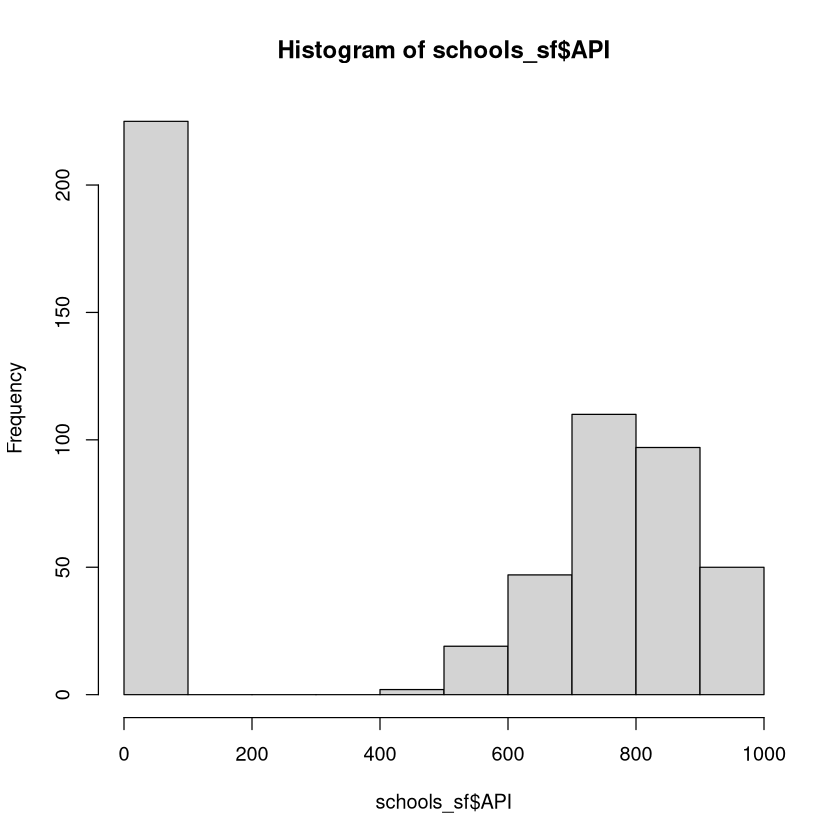

In [42]:
hist(schools_sf$API)

Oh, right! Those pesky schools with no reported APIs (i.e. API == 0)! Let's drop those.

In [43]:
schools_sf_api = schools_sf[schools_sf$API > 0, ]

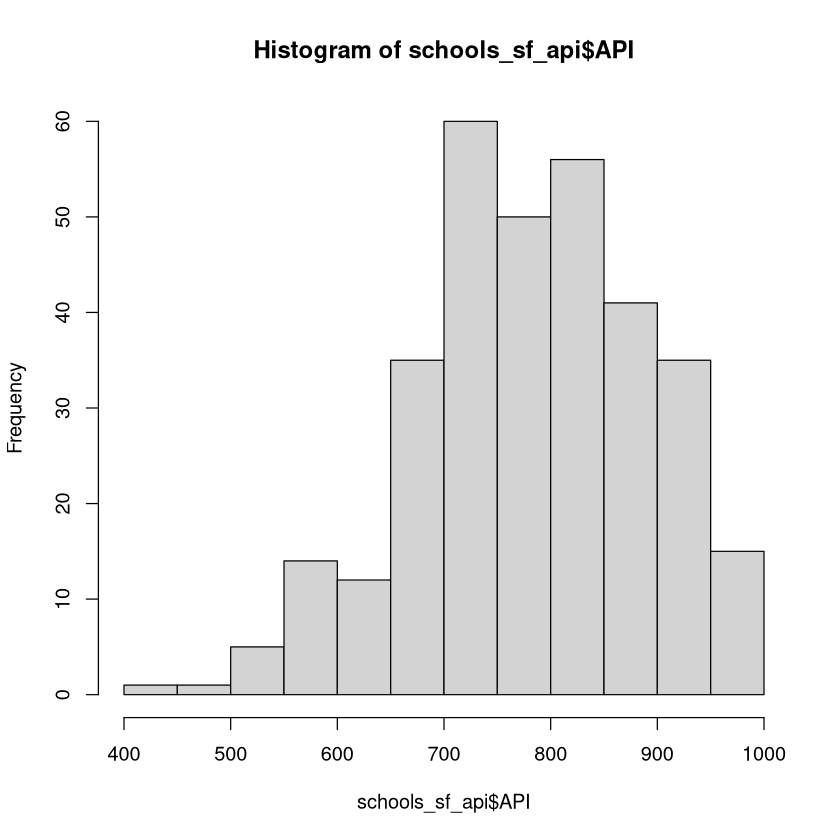

In [44]:
hist(schools_sf_api$API)

Much better!

Now, maybe we think there ought to be some correlation between the two variables?
As a first pass at this possibility, let's overlay the two datasets, coloring each one by
its variable of interest. This should give us a sense of whether or not similar values co-occur.

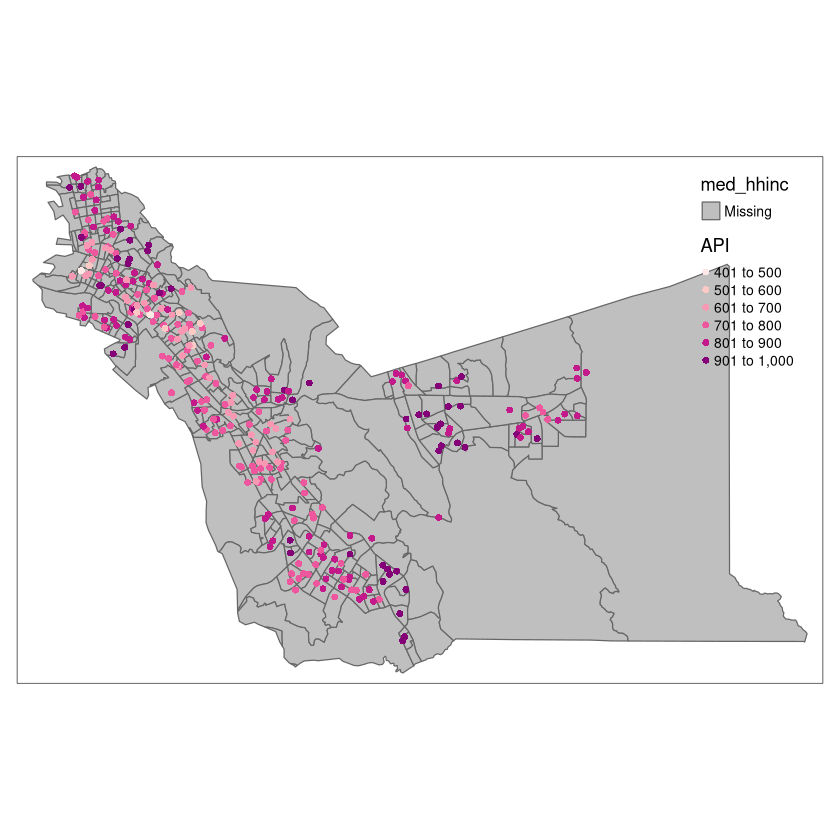

In [51]:
tm_shape(tracts_acs_sf_ac) + 
  tm_polygons(col = 'med_hhinc',
             palette = 'RdPu') + 
tm_shape(schools_sf_api) + 
  tm_dots(col = 'API',
          palette = 'RdPu',
          size = 0.15)

### Spatially Joining our Schools and Census Tracts

Though it's hard to say for sure, it certainly looks possible.
It would be ideal to scatterplot the variables! But in order to do that, 
we need to know the median household income in each school's tract, which
means we definitely need our **spatial join**!

We'll first take a look at the documentation for the spatial join function, `st_join`.

In [52]:
?st_join

Looks like the key arguments to consider are:
- the two `sf` data.frames (**`x`** and **`y`**)
- the type of join to run (**`left`**), which is a left join if `TRUE`, or an inner join if `FALSE`
- the spatial relationship query to use (**`join`**)

**NOTE**:
- By default `st_join` is a left join, because `left` defaults to TRUE. 

- By default `st_join` maintains the geometries of the first `sf` data.frame input to the operation (i.e. the geometries of `x`). 


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

1. Which `sf` data.frame are we joining onto which (i.e. which one is getting the other one's data added to it)?
1. What happened to 'outer' as a join type?
1. Thus, in our operation, which `sf` data.frame should be `x`, which should be `y`, and should `left` be `TRUE` or `FALSE`?

Alright! Let's run our join!

In [53]:
schools_jointracts = st_join(schools_sf_api, tracts_acs_sf_ac, left=T, join=st_within)

although coordinates are longitude/latitude, st_within assumes that they are planar



### Checking Our Output

<br>

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

As always, we want to sanity-check our intermediate result before we rush ahead.

One way to do that is to introspect the structure of the result object a bit.

1. What type of object should that have given us?
1. What should the dimensions of that object be, and why?
1. If we wanted a visual check of our results (i.e. a plot or map), what could we do?

In [55]:
print(dim(schools_jointracts))
print(dim(schools_sf))
print(dim(tracts_acs_sf_ac))

[1] 325  82
[1] 550   8
[1] 361  75


In [56]:
head(schools_jointracts)

ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called ‘geojsonio’

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

Site                      Address               City    State Type API Org   
1 Amelia Earhart Elementary 400 Packet Landing Rd Alameda CA    ES   933 Public
2 Bay Farm Elementary       200 Aughinbaugh Way   Alameda CA    ES   932 Public
3 Donald D. Lum Elementary  1801 Sandcreek Way    Alameda CA    ES   853 Public
4 Edison Elementary         2700 Buena Vista Ave  Alameda CA    ES   927 Public
5 Frank Otis Elementary     3010 Fillmore St      Alameda CA    ES   894 Public
6 Franklin Elementary       1433 San Antonio Ave  Alameda CA    ES   893 Public
  GEOID       STATEFP COUNTYFP geometry                   ⋯ p_movelocal
1 06001428302 06      001      POINT (-122.2388 37.74476) ⋯ NA         
2 06001428302 06      001      POINT (-122.2519 37.739)   ⋯ NA         
3 06001428500 06      001      POINT (-122.2589 37.76206) ⋯ NA         
4 06001427100 06      001      POINT (-122.2348 37.76525) ⋯ NA         
5 06001428200 06      001      POINT (-122.2381 37.75396) ⋯ NA         
6 06001427900 06      001      POINT (-122.2616 37.76911) ⋯ NA         
  p_movecounty p_movestate p_moveabroad p_car p_carpool p_transit p_bike p_walk
1 NA           NA          NA           NA    NA        NA        NA     NA    
2 NA           NA          NA           NA    NA        NA        NA     NA    
3 NA           NA          NA           NA    NA        NA        NA     NA    
4 NA           NA          NA           NA    NA        NA        NA     NA    
5 NA           NA          NA           NA    NA        NA        NA     NA    
6 NA           NA          NA           NA    NA        NA        NA     NA    
  geometry                  
1 POINT (-122.2388 37.74476)
2 POINT (-122.2519 37.739)  
3 POINT (-122.2589 37.76206)
4 POINT (-122.2348 37.76525)
5 POINT (-122.2381 37.75396)
6 POINT (-122.2616 37.76911)

Confirmed! The output of the our `st_join` operation is an `sf` data.frame (`schools_jointracts`) with:
- a row for each school that is located inside a census tract (all of them are)
- the **point geometry** of that school
- all of the attribute data columns (non-geometry columns) from both input `sf` data.frames

----------------------------

Let's also take a look at an overlay map of the schools on the tracts.
If we color the schools categorically by their tracts IDs, then we should see
that all schools within a given tract polygon are the same color.

Warning message:
“Number of levels of the variable "GEOID" is 208, which is larger than max.categories (which is 30), so levels are combined. Set tmap_options(max.categories = 208) in the layer function to show all levels.”


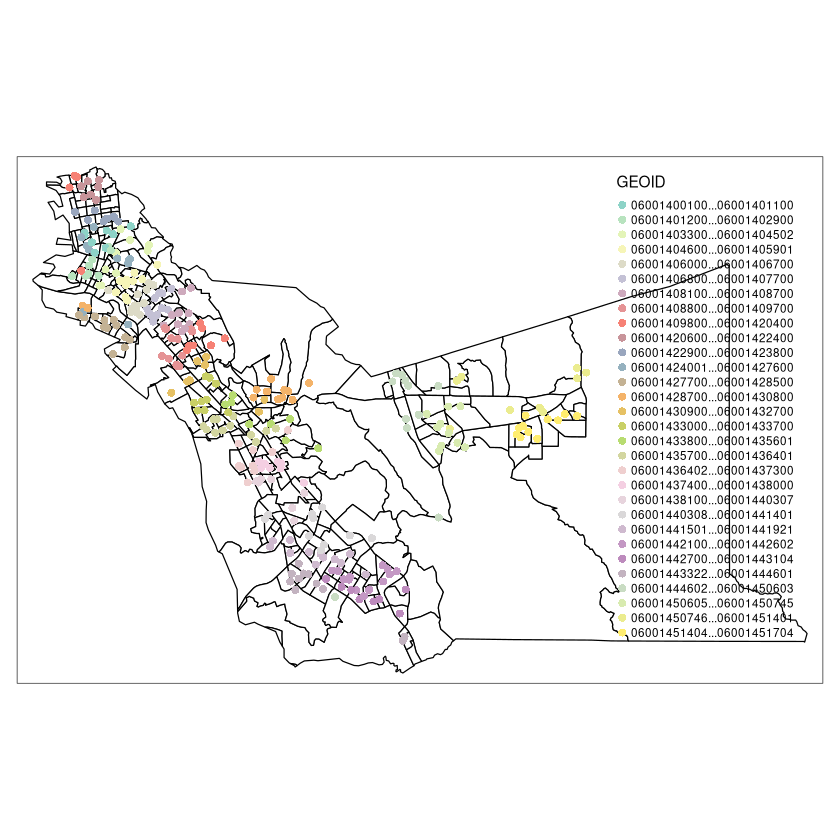

In [60]:
tm_shape(tracts_acs_sf_ac) + 
  tm_polygons(col='white', border.col='black') + 
tm_shape(schools_jointracts) + 
  tm_dots(col='GEOID', size=0.2)

### Assessing the Relationship between Median Household Income and API

Fantastic! That looks right!

Now we can create that scatterplot we were thinking about!

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in plot.window(...): need finite 'xlim' values


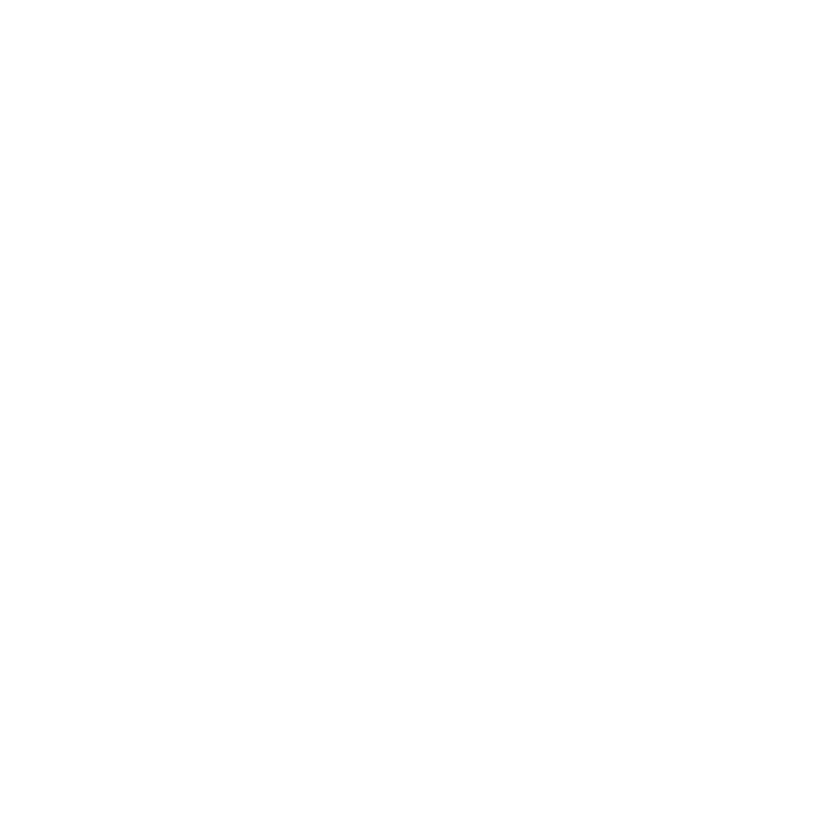

In [62]:
plot(schools_jointracts$med_hhinc, schools_jointracts$API)
     xlabel = 'median household income ($)',
     ylabel = 'API')

Wow! Just as we suspected based on our overlay map,
there's a pretty obvious, strong, and positive correlation
between median household income in a school's tract
and the school's API.

# 7.3: Aggregation

We just saw that a spatial join in one way to leverage the spatial relationship
between two datasets in order to create a new, synthetic dataset.

An **aggregation** is another way we can generate new data from this relationship.
In this case, for each feature in one dataset we find all the features in another
dataset that satisfy our chosen spatial relationship query with it (e.g. within, intersects),
then aggregate them using some summary function (e.g. count, mean).

------------------------------------

### Getting the Aggregated School Counts

Let's take this for a spin with our data. We'll count all the schools within each census tract.

We could do this using an aspatial group-by operation on the GEOID column of the new, spatially joined dataset that we just made. However, since we're in a geospatial workshop let's use a spatial aggregation instead!

(Also, to get the correct count, lets use all our schools, not just those with APIs > 0.)


In [82]:
schools_for_count = schools_sf['geometry']
schools_for_count$count = 1
schools_countsbytract = sf:::aggregate.sf(x=schools_for_count, by=tracts_acs_sf_ac, FUN=sum)


although coordinates are longitude/latitude, st_intersects assumes that they are planar



Let's see what we got out.

In [83]:
print("Counts, rows and columns:")
print(dim(schools_countsbytract))
print("Tracts, rows and columns:")
print(dim(tracts_acs_sf_ac))

# take a look at the data
head(schools_countsbytract)

[1] "Counts, rows and columns:"
[1] 361   2
[1] "Tracts, rows and columns:"
[1] 361  75


ERROR while rich displaying an object: Error in loadNamespace(name): there is no package called ‘geojsonio’

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_geojson.sf(o

,count,geometry
,<dbl>,<MULTIPOLYGON [°]>
1,1,MULTIPOLYGON (((-122.2469 3...
2,1,MULTIPOLYGON (((-122.2574 3...
3,NA,MULTIPOLYGON (((-122.2642 3...
4,2,MULTIPOLYGON (((-122.2618 3...
5,1,MULTIPOLYGON (((-122.2694 3...
6,NA,MULTIPOLYGON (((-122.2681 3...


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

1. Above we selected the geometry column, added a column of 1s, then aggregated. Why?
1. What explains the dimensions of the new object (361, 2)?

### Mapping our Spatial Join Output

As a sanity-check, we can now map the school counts for all census tracts.

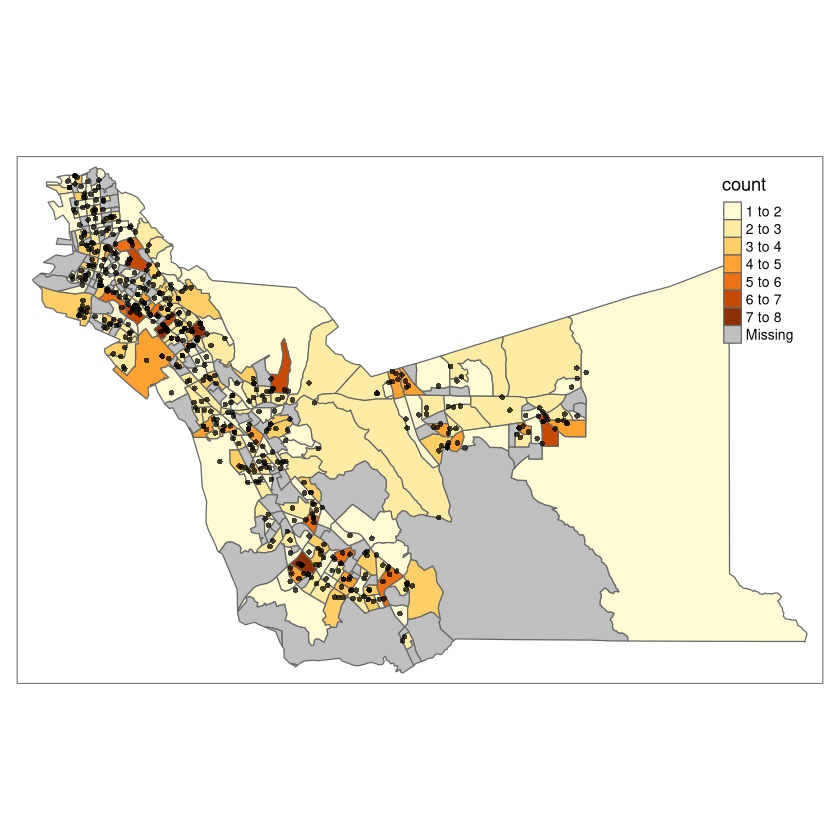

In [86]:
tm_shape(schools_countsbytract) + 
  tm_polygons(col='count') + 
tm_shape(schools_sf) + 
  tm_dots(col='black', alpha=0.75, size=0.1)

---------------------

# Exercise: Aggregation

#### What is the mean API of each census tract?

As we mentioned, the spatial aggregation workflow that we just put together above
could have been used not to generate a new count variable, but also
to generate any other new variable the results from calling an aggregation function
on an attribute column.

In this case, we want to calculate and map the mean API of the schools in each census tract.

Copy and paste code from above where useful, then tweak and/or add to that code such that your new code:
1. joins the schools onto the tracts (**HINT**: make sure to decide whether or not you want to include schools with API = 0!)
1. dissolves that joined object by the tract IDs, giving you a new GeoDataFrame with each tract's mean API (**HINT**: because this is now a different calculation, different problems may arise and need handling!)
1. plots the tracts, colored by API scores (**HINT**: overlay the schools points again, visualizing them in a way that will help you visually check your results!)

To see the solution, double-click the Markdown cell below.

In [ ]:
# YOUR CODE HERE:






## Double-click to see solution!

<!--

# SOLUTION:

# join the schools onto the tracks (excluding 0-API schools so that they don't skew our results!)
tracts_joinschools_api = gpd.sjoin(schools_gdf_api, tracts_acs_gdf_ac, how='right')

# dissolve the tracts by GEOID, using 'API' as the column we'll aggregate and 'mean' as our aggfunc
tracts_meanAPI = tracts_joinschools_api[['GEOID', 'API', 'geometry']].dropna(how='any').dissolve(by='GEOID',
                                                                                                 aggfunc='mean')

# plot the tracts, coloring them by mean API
fig, ax = plt.subplots(figsize = (20,20)) 
tracts_meanAPI.plot(ax=ax,column='API', 
                    scheme='equalinterval',
                    cmap="cool_r",
                    edgecolor="grey",
                    legend=True, legend_kwds={'title': 'mean API (tracts)'})
# add the schools, coloring them by API (so we can check that the mean APIs we calculated are resonable)
schools_gdf_api.plot(ax=ax, column='API', cmap='cool_r', edgecolor='black', linewidth=0.3, markersize=25,
                 legend=True, legend_kwds={'label': "API (schools)", 'orientation': "horizontal"})

-->

----------------------------

## 7.4 Recap
We discussed how we can combine datasets to enhance any geospatial data analyses you could do. Key concepts include:
-  Attribute joins
	- `merge()`
- Spatial joins (order matters!)
	- `st_join`
- Aggregation
	- `aggregate.sf`

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        


